In [54]:
#!/usr/bin/env python
from copy import copy
from sklearn.preprocessing import OneHotEncoder
import gzip
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import sys
import time
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

Helper Code
----------------

Feel free to skip reading this part, unless you are curious.

NB: You need to run the BASH script in this folder `data/download_mnist.sh` to be able to run the experiments involving MNIST. Do this now.

In [55]:
class Normalizer:
    def __init__(self):
        self.mean = 0
        self.std = 0

    def normalize(self, X, train=True):
        """normalizes an sample x to have 0 mean and unit standard deviation"""
        if train:
            self.mean = np.mean(X)
            self.std = np.mean(X)

        return((X - self.mean)/self.std)


def load_mnist_raw(path, kind='train'):
    """Load Fashion MNIST data from path"""
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte.gz' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte.gz' % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
            offset=16).reshape(len(labels), 784)

    return(images, labels)


def make_mnist_proc(output):

    if os.path.isfile(output):
        print('preprocessed MNIST already exists, skipping preprocessing')
        return(None)

    split = 50000
    X_train, y_train = load_mnist_raw('data/', kind='train')
    X_test, y_test = load_mnist_raw('data/', kind='t10k')

    X_valid = X_train[split:, :]
    X_train = X_train[:split, :]
    y_valid = y_train[split:]
    y_train = y_train[:split]

    norm_buddy = Normalizer()
    X_train = norm_buddy.normalize(X_train)
    X_valid = norm_buddy.normalize(X_valid, train=False)
    X_test  = norm_buddy.normalize(X_test, train=False)

    data = {"X": {"train": X_train, "valid": X_valid, "test": X_test},
            "y": {"train": y_train, "valid": y_valid, "test": y_test}}

    print('saving preprocessed MNIST data at {}'.format(output))
    with open(output, 'wb') as f:
        pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)


def load_pickle(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f)

    return(data)


def get_circles_data():
    data = np.loadtxt(open('data/circles.txt','r'))
    X = data[:, :2]
    y = data[:, 2]

    X_train = X[:800, :]
    X_valid = X[800:950, :]
    X_test  = X[950:, :]
    y_train = y[:800]
    y_valid = y[800:950]
    y_test  = y[950:]

    data = {"X": {"train": X_train, "valid": X_valid, "test": X_test},
            "y": {"train": y_train, "valid": y_valid, "test": y_test}}

    return(data)


def get_minibatches(n, size):
    """
    gets a bunch of minibatches of the defined size (roughly) out of
    the n samples.
    """  
    assert 1 < size < n
    
    idx = np.arange(n)
    np.random.shuffle(idx)

    # In case the minibatch size does not evenly divide into the samples.
    rem = n % size
    if rem != 0:
        idx = np.hstack((idx, np.repeat(-1, (size-rem))))

    # Reshape into a list of numpy arrays.
    mbs = []
    idx = idx.reshape(int(len(idx) / size), size)
    for mb in np.arange(idx.shape[0]):
        mbs.append(idx[mb, :])

    # If -1's are in the final batch, remove them.
    mbs[-1] = np.delete(mbs[-1], np.where(mbs[-1] == -1)[0])
    if len(mbs[-1]) == 0: 
        mbs = mbs[:-1]
        
    return mbs


def plot_decision(model, X, y, title="", h=0.07):
    """plot the decision boundary. h controls plot quality."""
    fig, ax = plt.subplots(figsize=(7, 6))

    # https://stackoverflow.com/a/19055059/6027071
    # sample a region larger than our training data X
    x_min = X[:, 0].min() - 0.5
    x_max = X[:, 0].max() + 0.5
    y_min = X[:, 1].min() - 0.5
    y_max = X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Plot decision boundaries.
    tiles_X = np.concatenate(([xx.ravel()], [yy.ravel()]))
    tiles_y = np.zeros(tiles_X.shape[1])  
    pred, _, _ = model.pass_data(tiles_X.T, tiles_y)
    pred = pred.reshape(xx.shape)
    ax.contourf(xx, yy, pred, alpha=0.8,cmap='RdYlBu')

    # Plot points (coloured by class).
    ax.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, cmap='RdYlBu')
    ax.axis('off')

    ax.set_title("Decision Boundary: {}".format(title))
    plt.show()
    

def plot_results(results, title):
    
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))

    for i, result_type in enumerate(results.keys()):  
        ax = axs.ravel()[i]
        ax.plot(results[result_type]['train'], 
                label='{} {}'.format(result_type, 'train'))
        ax.plot(results[result_type]['valid'], 
                label='{} {}'.format(result_type, 'valid'))
        ax.plot(results[result_type]['test'], 
                label='{} {}'.format(result_type, 'test'))
        ax.legend()
        ax.set_ylabel(result_type)                                             
        ax.set_xlabel('epoch')
        ax.set_title(title)
        
    plt.tight_layout()                                                          
    plt.show()

The Data
-------------

+ `circles`: a 2D, two-class problem where the decision boundary is a circle. 
+ `fashion mnist`: like mnist, but with clothes.

preprocessed MNIST already exists, skipping preprocessing


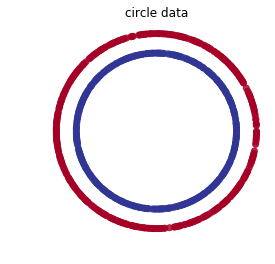

Text(0.5, 0.98, 'fashion MNIST')

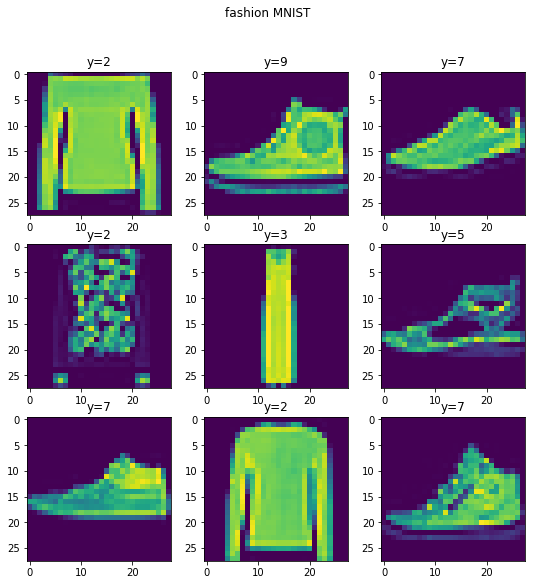

In [56]:
# Use helper functions to load the data.
circle_data = get_circles_data()
make_mnist_proc('data/fashion_mnist.pkl')
mnist_data = load_pickle('data/fashion_mnist.pkl')

# Plot the circle data.
X = circle_data['X']['train']
y = circle_data['y']['train']
plt.figure(figsize=(4,4))
plt.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, cmap='RdYlBu')
plt.axis('off')
plt.title('circle data')
plt.show()

# Plot some examples from Fashion MNIST.
X = mnist_data['X']['train']
y = mnist_data['y']['train']

fig, axs = plt.subplots(3, 3, figsize=(9, 9))
for ax in axs.ravel():
    
    example = np.random.choice(range(len(X)))
    x_sample = X[example, :]
    y_sample = y[example]
    
    # Reshape the images to be a square, they're flat for our MLP.
    x_sample = x_sample.reshape((28, 28))
    
    ax.imshow(x_sample)
    ax.set_title('y={}'.format(y_sample))
    
fig.suptitle("fashion MNIST")

Data Handling
--------------------

The data structure we're using is nested dictionaries with train, valid, and test splits for both X and y:

In [59]:
X = circle_data['X']['train'] 
y = circle_data['y']['train']

The Forward Pass
--------------------------

In [60]:
def relu(X):
    """
    ReLU is the maximum of 0 and X, aka, a rectifier activation.
    """
    return np.maximum(np.zeros(X.shape), X)

def softmax(X):
    """
    Numerically stable softmax (note the subtraction of the max).
    """
    exps = np.exp(X - np.max(X, axis=1).reshape(-1, 1))
    exps /= np.sum(exps, axis=1).reshape(-1, 1)
    
    return exps 

def forward(X, W, b, activation):
    """
    Passes the data X through the weights W, applying the bias b, 
    and finally the activation function supplied.
    """
    pre_activations = X.dot(W) + b
    outputs = activation(pre_activations)
    
    return (pre_activations, outputs)

The Loss
-------------

In [61]:
class NLLLoss:
    """Calculates the negative log likelyhood loss."""
    def __init__(self, n_out):
        self.onehot = OneHotEncoder(sparse=False, n_values=n_out)
        
    def __call__(self, y_hat, y):
        """
        Negative log likelihood loss between the prediction y_hat and the
        ground-truth labels y.
        """
        y_one = self.onehot.fit_transform(y.reshape(-1,1))
        prob = np.einsum('ky,ky->k', y_hat, y_one)
        loss = -np.log(prob)

        return loss

    
def l2_reg_loss(W):
    """Calculates the L2 penalty to apply to the weights."""
    l2_loss = np.sum(np.square(W))
    
    return l2_loss

Predictions
----------------

In [62]:
def predict(y_hat):
    """
    The outputs of a softmax are probabilities, we take the max 
    as our hard prediction.
    """
    pred = np.argmax(y_hat.T, axis=0)
    return pred


def accuracy(pred, y):
    """
    Percentage of responses that are correct.
    """
    correct = np.sum(pred == y)
    total = len(y)
    acc = (correct / float(total)) * 100
    return acc


The Backward Pass
--------------------------

In [63]:
class SoftmaxBackward:
    """backprop of softmax"""
    def __init__(self, n_out):
        self.onehot = OneHotEncoder(sparse=False, n_values=n_out)
        
    def __call__(self, y_hat, y):
        y_one = self.onehot.fit_transform(y.reshape(-1,1))
        return y_hat - y_one

def relu_backward(z):
    """if previous layer pre-activated vals were <= 0, also set z to 0"""
    z[z <= 0] = 0
    z[z > 0] = 1
    return z

Weight Initialization
--------------------------

In [64]:
def init_W(n_in, n_out):
    """initializes weight matrix using glorot initialization."""
    # Sample weights uniformly from [-1/sqrt(in), 1/np.sqrt(in)].
    bound = 1/np.sqrt(n_in)
    W = np.random.uniform(low=-bound, high=bound, size=(n_in, n_out))
    return W

def init_b(n_out):
    """Initializes a bias vector the size of the output layer."""
    b = np.zeros(n_out)
    return b

Model
--------

In [65]:
class MLP:
    def __init__(self, **kwargs):

        hyperparameters = {
            'n_in'  : 784,
            'n_hid' : 10,
            'n_out' : 10,
            'lr'     : 0.01,
            'l2'     : 0,
        }

        hyperparameters.update(kwargs)

        self.n_in = hyperparameters['n_in']     # input dimensions
        self.n_hid = hyperparameters['n_hid']   # number of hidden units
        self.n_out = hyperparameters['n_out']   # number of output units
        self.lr  = hyperparameters['lr']        # learning rate
        self.l2 = hyperparameters['l2']         # lambda l1

        # Construct network and initialize weights.
        self.W1 = init_W(self.n_in, self.n_hid)
        self.W2 = init_W(self.n_hid, self.n_out)
        self.b1 = init_b(self.n_hid)
        self.b2 = init_b(self.n_out)

        # for loss calculation
        self.negative_log_likelyhood = NLLLoss(self.n_out)
        
        # for backprop
        self.softmax_backward = SoftmaxBackward(self.n_out)
        
    def pass_data(self, X, y, train=False):
        """take inputs, and push them through to produce a prediction y"""

        batch_size = X.shape[0]
        
        hid_preact, hid = forward(X, self.W1, self.b1, relu)
        out_preact, y_hat = forward(hid, self.W2, self.b2, softmax)

        pred = predict(y_hat)
        acc = accuracy(pred, y)
        
        # Calculating the loss.
        loss = self.negative_log_likelyhood(y_hat, y)
        loss += l2_reg_loss(self.W1) * self.l2
        loss += l2_reg_loss(self.W2) * self.l2
        
        if train:

            # Gradients for output --> hidden layer.
            dloss_y_hat = self.softmax_backward(y_hat, y)
            dloss_W2 = hid.T.dot(dloss_y_hat) / batch_size   
            dloss_b2 = np.sum(dloss_y_hat, axis=0) / batch_size 
            
            # Gradients for hidden --> input layer.
            dloss_out_preact = self.W2.dot(dloss_y_hat.T)
            dloss_hid = relu_backward(hid) * dloss_out_preact.T
            dloss_W1  = X.T.dot(dloss_hid) / batch_size 
            dloss_b1  = np.sum(dloss_hid, axis=0) / batch_size
            
            assert dloss_W1.shape == self.W1.shape
            assert dloss_W2.shape == self.W2.shape
            assert dloss_b1.shape == self.b1.shape
            assert dloss_b2.shape == self.b2.shape
            
            # Weight Decay Regularization.
            reg_W1 = (self.l2 * 2 * self.W1)
            reg_W2 = (self.l2 * 2 * self.W2)

            # Gradient Descent!
            self.W1 -= self.lr * (dloss_W1 + reg_W1)
            self.W2 -= self.lr * (dloss_W2 + reg_W2)    
            self.b1 -= self.lr * (dloss_b1)
            self.b2 -= self.lr * (dloss_b2)

        return (pred, loss, acc)

Training / Evaluation Loop
-----------------------------------

In [66]:
def run_epoch(model, batch_size, X, y, train=False):
    
    minibatches = get_minibatches(X.shape[0], batch_size)

    total_acc = 0
    total_loss = 0

    for j, batch in enumerate(minibatches):
        _, loss, acc = model.pass_data(X[batch, :], y[batch], train=train)
        total_acc += np.mean(acc)
        total_loss += np.mean(loss)

    total_acc /= len(minibatches)
    total_loss /= len(minibatches)

    return (total_acc, total_loss)


def train_model(model, data, epochs=100, batch_size=32, verbose=False):
    
    results = {'loss':{'train': [], 'valid' : [], 'test': []},
               'accuracy': {'train': [], 'valid': [], 'test': []}}

    # Unpack the data.
    X_train = data['X']['train']
    y_train = data['y']['train']
    X_valid = data['X']['valid']
    y_valid = data['y']['valid']
    X_test = data['X']['test']
    y_test = data['y']['test']
        
    for i in range(epochs):

        train_acc, train_loss = run_epoch(model, batch_size, X_train, y_train, train=True)
        if verbose:
            print('TRAIN [epoch {}]: accuracy={:.4f}, loss={:.4f}'.format(i+1, train_acc, train_loss))

        valid_acc, valid_loss = run_epoch(model, batch_size, X_valid, y_valid, train=False)
        if verbose:
            print('VALID [epoch {}]: accuracy={:.4f}, loss={:.4f}'.format(i+1, valid_acc, valid_loss))

        test_acc, test_loss = run_epoch(model, batch_size, X_test, y_test, train=False)
        if verbose:
            print('TEST  [epoch {}]: accuracy={:.4f}, loss={:.4f}'.format(i+1, test_acc, test_loss))

        # store end-of-epoch results for train, valid, test
        results['loss']['train'].append(train_loss)
        results['loss']['valid'].append(valid_loss)
        results['loss']['test'].append(test_loss)
        results['accuracy']['train'].append(train_acc)
        results['accuracy']['valid'].append(valid_acc)
        results['accuracy']['test'].append(test_acc)

    return(results)

Let's Train!
----------------

In [67]:
# Circles Data
circles_model = MLP(n_in=2, n_hid=100, n_out=2, lr=0.1)
circles_results = train_model(circles_model, circle_data, epochs=50, batch_size=32, verbose=True)

TRAIN [epoch 1]: accuracy=50.8750, loss=0.6877
VALID [epoch 1]: accuracy=50.2841, loss=0.6800
TEST  [epoch 1]: accuracy=49.9432, loss=0.6865
TRAIN [epoch 2]: accuracy=51.8750, loss=0.6760
VALID [epoch 2]: accuracy=53.0682, loss=0.6657
TEST  [epoch 2]: accuracy=51.4773, loss=0.6761
TRAIN [epoch 3]: accuracy=56.6250, loss=0.6641
VALID [epoch 3]: accuracy=56.3068, loss=0.6568
TEST  [epoch 3]: accuracy=59.2614, loss=0.6627
TRAIN [epoch 4]: accuracy=65.2500, loss=0.6498
VALID [epoch 4]: accuracy=49.1477, loss=0.6526
TEST  [epoch 4]: accuracy=49.3750, loss=0.6544
TRAIN [epoch 5]: accuracy=64.7500, loss=0.6417
VALID [epoch 5]: accuracy=59.8864, loss=0.6310
TEST  [epoch 5]: accuracy=59.3182, loss=0.6380
TRAIN [epoch 6]: accuracy=72.8750, loss=0.6302
VALID [epoch 6]: accuracy=53.7500, loss=0.6191
TEST  [epoch 6]: accuracy=51.9318, loss=0.6247
TRAIN [epoch 7]: accuracy=72.8750, loss=0.6172
VALID [epoch 7]: accuracy=95.0568, loss=0.6059
TEST  [epoch 7]: accuracy=91.5909, loss=0.6122
TRAIN [epoch 

In [45]:
# MNIST Data
mnist_model = MLP(n_in=784, n_hid=100, n_out=10, lr=0.1)
mnist_results = train_model(mnist_model, mnist_data, epochs=50, batch_size=32, verbose=True)

TRAIN [epoch 1]: accuracy=81.7918, loss=0.5007
VALID [epoch 1]: accuracy=82.2584, loss=0.4830
TEST  [epoch 1]: accuracy=81.5895, loss=0.5151
TRAIN [epoch 2]: accuracy=86.1884, loss=0.3773
VALID [epoch 2]: accuracy=85.3235, loss=0.3938
TEST  [epoch 2]: accuracy=84.8043, loss=0.4077
TRAIN [epoch 3]: accuracy=87.5360, loss=0.3404
VALID [epoch 3]: accuracy=86.8211, loss=0.3634
TEST  [epoch 3]: accuracy=86.0523, loss=0.3890
TRAIN [epoch 4]: accuracy=88.4917, loss=0.3118
VALID [epoch 4]: accuracy=85.8027, loss=0.4066
TEST  [epoch 4]: accuracy=85.2336, loss=0.4268
TRAIN [epoch 5]: accuracy=89.2254, loss=0.2935
VALID [epoch 5]: accuracy=88.0491, loss=0.3431
TEST  [epoch 5]: accuracy=87.1306, loss=0.3693
TRAIN [epoch 6]: accuracy=89.7393, loss=0.2782
VALID [epoch 6]: accuracy=87.0308, loss=0.3703
TEST  [epoch 6]: accuracy=86.4617, loss=0.3942
TRAIN [epoch 7]: accuracy=90.1611, loss=0.2651
VALID [epoch 7]: accuracy=86.2121, loss=0.3834
TEST  [epoch 7]: accuracy=85.9125, loss=0.4052
TRAIN [epoch 

VALID [epoch 58]: accuracy=88.3986, loss=0.6249
TEST  [epoch 58]: accuracy=87.5499, loss=0.7219
TRAIN [epoch 59]: accuracy=97.2889, loss=0.0731
VALID [epoch 59]: accuracy=88.1290, loss=0.6454
TEST  [epoch 59]: accuracy=87.5499, loss=0.7310
TRAIN [epoch 60]: accuracy=97.4048, loss=0.0686
VALID [epoch 60]: accuracy=87.9193, loss=0.6633
TEST  [epoch 60]: accuracy=87.2804, loss=0.7389
TRAIN [epoch 61]: accuracy=97.3588, loss=0.0691
VALID [epoch 61]: accuracy=87.9792, loss=0.7030
TEST  [epoch 61]: accuracy=87.2404, loss=0.7901
TRAIN [epoch 62]: accuracy=97.4128, loss=0.0702
VALID [epoch 62]: accuracy=88.1090, loss=0.6852
TEST  [epoch 62]: accuracy=87.2204, loss=0.7647
TRAIN [epoch 63]: accuracy=97.4188, loss=0.0682
VALID [epoch 63]: accuracy=88.4984, loss=0.6583
TEST  [epoch 63]: accuracy=87.7895, loss=0.7467
TRAIN [epoch 64]: accuracy=97.4088, loss=0.0707
VALID [epoch 64]: accuracy=87.3403, loss=0.7529
TEST  [epoch 64]: accuracy=86.4317, loss=0.8580
TRAIN [epoch 65]: accuracy=97.6088, loss

Decision Boundary
--------------------------

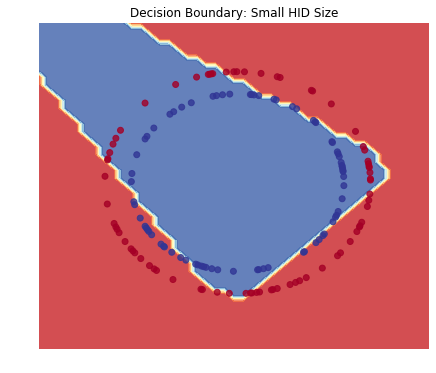

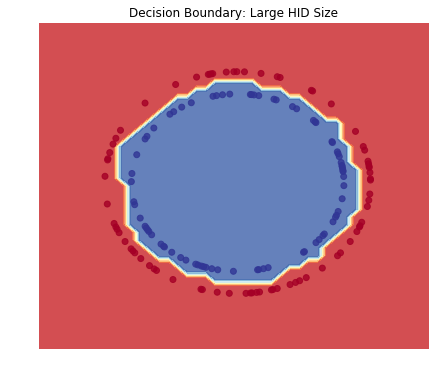

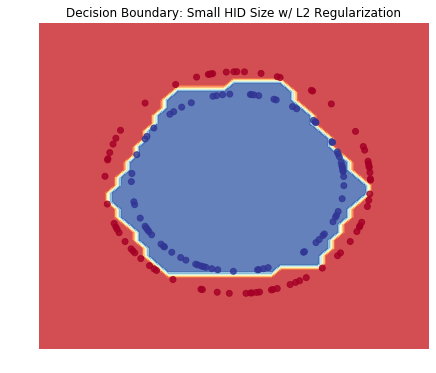

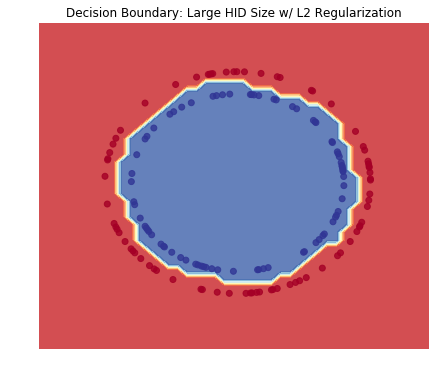

In [33]:
X_valid = circle_data['X']['valid']
y_valid = circle_data['y']['valid']

EPOCHS = 100
BATCH_SIZE = 32

model = MLP(n_in=2, n_hid=3, n_out=2, lr=0.1)
_ = train_model(model, circle_data, epochs=EPOCHS, batch_size=BATCH_SIZE)
plot_decision(model, X_valid, y_valid, title="Small HID Size");

model = MLP(n_in=2, n_hid=10, n_out=2, lr=0.1)
_ = train_model(model, circle_data, epochs=EPOCHS, batch_size=BATCH_SIZE)
plot_decision(model, X_valid, y_valid, title="Large HID Size")

model = MLP(n_in=2, n_hid=3, n_out=2, lr=0.1, l2=0.001)
_ = train_model(model, circle_data, epochs=EPOCHS, batch_size=BATCH_SIZE)
plot_decision(model, X_valid, y_valid, title="Small HID Size w/ L2 Regularization");

model = MLP(n_in=2, n_hid=10, n_out=2, lr=0.1, l2=0.001)
_ = train_model(model, circle_data, epochs=EPOCHS, batch_size=BATCH_SIZE)
plot_decision(model, X_valid, y_valid, title="Large HID Size w/ L2 Regularization");

Training Curves
-----------------------

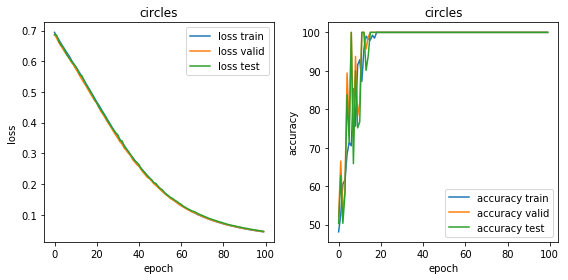

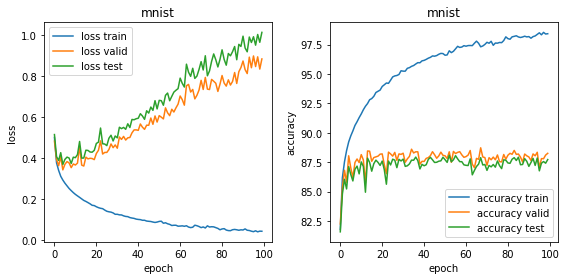

In [53]:
plot_results(circles_results, 'circles');
plot_results(mnist_results, 'mnist')